## Modules & Functions

In [1]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pylab as pl,pandas as pd
import sys,h5py,urllib,zipfile
import tensorflow as tf
import tensorflow_hub as th
from sklearn.model_selection import train_test_split

In [2]:
def prepro(x_train,y_train,x_test,y_test,n_class):
    n=int(len(x_test)/2)
    x_train=x_train.astype('float32')/255
    x_test=x_test.astype('float32')/255
    y_train=y_train.astype('int32')
    y_test=y_test.astype('int32')    
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    cy_train=tf.keras.utils.to_categorical(y_train,n_class) 
    cy_valid=tf.keras.utils.to_categorical(y_valid,n_class)
    cy_test=tf.keras.utils.to_categorical(y_test,n_class)
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [y_train.shape,y_valid.shape,y_test.shape],
                     [cy_train.shape,cy_valid.shape,cy_test.shape]],
                    columns=['train','valid','test'],
                    index=['images','labels','encoded labels'])
    display(df)
    return [[x_train,x_valid,x_test],
            [y_train,y_valid,y_test],
            [cy_train,cy_valid,cy_test]]
def display_10img(X,y,s):
    fig,ax=pl.subplots(figsize=(10,3),nrows=2,ncols=5,
                       sharex=True,sharey=True)
    ax=ax.flatten()
    for i in range(10):
        ax[i].imshow(X[i].reshape(s,s,3),cmap=pl.cm.Pastel1)
        ax[i].set_title(y[i])
    ax[0].set_xticks([]); ax[0].set_yticks([])
    pl.tight_layout()
def display_resize(x_train,x_valid,x_test,
                   y_valid,cy_valid,pixels):
    x_train=tf.image.resize(x_train,[pixels,pixels])
    x_valid=tf.image.resize(x_valid,[pixels,pixels])
    x_test=tf.image.resize(x_test,[pixels,pixels])
    img=x_valid[1]
    lbl='one example of resized images \nlabel: '+\
     str(y_valid[1][0])+'=>'+str(cy_valid[1])+\
     '\nshape: '+str(img.shape)
    pl.imshow(img); pl.title(lbl)
    return [x_train,x_valid,x_test]
def cb(fw):
    early_stopping=tf.keras.callbacks\
    .EarlyStopping(monitor='val_loss',patience=20,verbose=2)
    checkpointer=tf.keras.callbacks\
    .ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
    lr_reduction=tf.keras.callbacks\
    .ReduceLROnPlateau(monitor='val_loss',verbose=2,
                       patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

## Data

170500096/170498071 [==============================] - 3s 0us/step


,train,valid,test
images,"(50000, 32, 32, 3)","(5000, 32, 32, 3)","(5000, 32, 32, 3)"
labels,"(50000, 1)","(5000, 1)","(5000, 1)"
encoded labels,"(50000, 10)","(5000, 10)","(5000, 10)"


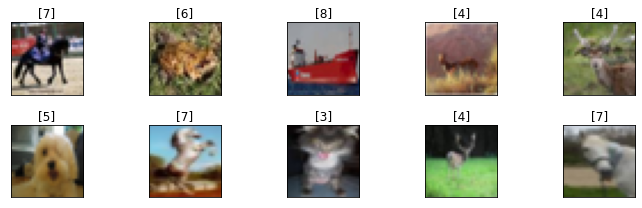

In [3]:
(x_train1,y_train1),(x_test1,y_test1)=\
tf.keras.datasets.cifar10.load_data()
[[x_train1,x_valid1,x_test1],
 [y_train1,y_valid1,y_test1],
 [cy_train1,cy_valid1,cy_test1]]=\
prepro(x_train1,y_train1,x_test1,y_test1,10)
display_10img(x_test1,y_test1,32)

## Simple MLP Building & Training

In [4]:
lr=.001; epochs=15
hidden1=512; hidden2=256
batch_size=128; display_step=1 
n_inputs=32*32*3; n_classes=10

In [5]:
def cat_accuracy(predictions,labels):
    return (100.0*np.sum(np.argmax(predictions,1)==\
           np.argmax(labels,1))/predictions.shape[0])
def mlp(x):
    layer1=tf.add(tf.matmul(x,weights['W1']),biases['b1'])
    layer2=tf.add(tf.matmul(layer1,weights['W2']),biases['b2'])
    return tf.matmul(layer2,weights['out'])+biases['out']

In [6]:
tf.compat.v1.reset_default_graph()
graph=tf.Graph()
with graph.as_default():
    X=tf.compat.v1.placeholder("float32",[None,n_inputs])
    y=tf.compat.v1.placeholder("int32",[None,n_classes])
    vX=tf.constant(x_test1.reshape(-1,32*32*3))
    weights={'W1':tf.Variable(\
                  tf.compat.v1.random_normal([n_inputs,hidden1])),
             'W2':tf.Variable(\
                  tf.compat.v1.random_normal([hidden1,hidden2])),
             'out':tf.Variable(\
                   tf.compat.v1.random_normal([hidden2,n_classes]))}
    biases={'b1':tf.Variable(\
                 tf.compat.v1.random_normal([hidden1])),
            'b2':tf.Variable(\
                 tf.compat.v1.random_normal([hidden2])),
            'out':tf.Variable(\
                  tf.compat.v1.random_normal([n_classes]))}
    logits=mlp(X); vlogits=mlp(vX)
    loss=tf.reduce_mean(\
    tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y))
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=lr)
    train_opt=optimizer.minimize(loss)
    train_predictions=tf.nn.softmax(logits)
    test_predictions=tf.nn.softmax(vlogits)

In [7]:
config=tf.compat.v1.ConfigProto()
with tf.compat.v1.Session(graph=graph,config=config) as sess:
    tf.compat.v1.global_variables_initializer().run()
    for epoch in range(epochs):
        avg_loss=0.; avg_acc=0.
        total_batch=int(x_train1.shape[0]/batch_size)
        for i in range(total_batch):
            offset=(i*batch_size)%(x_train1.shape[0]-batch_size)
            batch_X=x_train1.reshape(-1,32*32*3)[offset:(offset+batch_size)]
            batch_y=cy_train1[offset:(offset+batch_size)]
            _,l,batch_py=sess.run([train_opt,loss,train_predictions],
                                  feed_dict={X:batch_X,y:batch_y})
            avg_loss+=l/total_batch
            avg_acc+=cat_accuracy(batch_py,batch_y)/total_batch
        if epoch%display_step==0:
            print("Epoch: %04d"%(epoch+1),
                  "loss={:.9f}".format(avg_loss),
                  "accuracy={:.3f}".format(avg_acc))
    print("Test accuracy: %.3f%%"%\
    cat_accuracy(test_predictions.eval(),cy_test1))

Epoch: 0001 loss=2879.030253405 accuracy=21.506
Epoch: 0002 loss=1653.398043745 accuracy=25.278
Epoch: 0003 loss=1277.107985589 accuracy=26.260
Epoch: 0004 loss=1089.357193228 accuracy=26.765
Epoch: 0005 loss=948.601942013 accuracy=27.436
Epoch: 0006 loss=839.247663606 accuracy=27.750
Epoch: 0007 loss=752.580780577 accuracy=28.271
Epoch: 0008 loss=701.113872274 accuracy=28.295
Epoch: 0009 loss=651.242094304 accuracy=28.387
Epoch: 0010 loss=599.708594689 accuracy=28.460
Epoch: 0011 loss=548.223565361 accuracy=28.828
Epoch: 0012 loss=519.245290668 accuracy=28.808
Epoch: 0013 loss=478.133978663 accuracy=29.077
Epoch: 0014 loss=451.177770370 accuracy=29.071
Epoch: 0015 loss=432.080143464 accuracy=28.900
Test accuracy: 26.060%


## Simple CNN Building & Training

In [8]:
lr=.0005; epochs=100; 
batch_size=64; display_step=5 
img_size=32; n_classes=10
save_model_path='./img_class'

In [9]:
def cnn(x,n_classes,conv1,conv2,dense1):
    W1=tf.Variable(tf.compat.v1\
         .truncated_normal([2,2,x.shape[3],conv1],stddev=.04))
    b1=tf.Variable(tf.compat.v1\
         .constant(.04,shape=[conv1]))
    x=tf.nn.conv2d(x,W1,strides=[1,5,5,1],padding='SAME')
    x=tf.nn.relu(x+b1)
    x=tf.nn.max_pool(x,ksize=[1,2,2,1], 
                     strides=[1,2,2,1],padding='SAME')
    x=tf.nn.dropout(x,.2)
    W2=tf.Variable(tf.compat.v1\
         .truncated_normal([2,2,x.shape[3],conv2],stddev=.04))
    b2=tf.Variable(tf.compat.v1\
         .constant(.04,shape=[conv2]))
    x=tf.nn.conv2d(x,W2,strides=[1,2,2,1],padding='SAME')
    x=tf.nn.relu(x+b2)
    x=tf.nn.max_pool(x,ksize=[1,2,2,1], 
                     strides=[1,2,2,1],padding='SAME')
    x=tf.nn.dropout(x,.2)
    x=tf.reshape(x,[-1,x.shape[1]*x.shape[2]*x.shape[3]])
    W3=tf.Variable(tf.compat.v1.\
    truncated_normal([x.shape[1],dense1],stddev=.04))
    b3=tf.Variable(tf.compat.v1.truncated_normal([dense1],stddev=.04))
    x=tf.nn.relu(tf.add(tf.matmul(x,W3),b3)) 
    W=tf.Variable(tf.compat.v1.\
    truncated_normal([x.shape[1],n_classes],stddev=.04))
    b=tf.Variable(tf.compat.v1.truncated_normal([n_classes],stddev=.04))
    x=tf.add(tf.matmul(x,W),b)
    return x

In [10]:
tf.compat.v1.reset_default_graph()
graph=tf.Graph()
with graph.as_default():
    X=tf.compat.v1.\
    placeholder("float32",[None,img_size,img_size,3],name='x')
    y=tf.compat.v1.placeholder("int32",[None,n_classes],name='y')
    logits=cnn(X,n_classes,32,196,512)
    logits=tf.compat.v1.identity(logits,name='logits')
    loss=tf.reduce_mean(\
    tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y))
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=lr)
    train_opt=optimizer.minimize(loss)
    train_predictions=tf.nn.softmax(logits)
    correct_predictions=tf.equal(tf.argmax(train_predictions,1),
                                 tf.argmax(y,1))
    accuracy=tf.reduce_mean(tf.cast(correct_predictions,tf.float32),
                            name='accuracy')

In [11]:
config=tf.compat.v1.ConfigProto()
with tf.compat.v1.Session(graph=graph,config=config) as sess:
    tf.compat.v1.global_variables_initializer().run()
    for epoch in range(epochs):
        avg_loss=0.; avg_acc=0.
        total_batch=int(x_train1.shape[0]/batch_size)
        for i in range(total_batch):
            offset=(i*batch_size)%(x_train1.shape[0]-batch_size)
            batch_X=x_train1[offset:(offset+batch_size)]
            batch_y=cy_train1[offset:(offset+batch_size)]
            _,l,_,_,acc=sess.run([train_opt,loss,train_predictions,
                                  correct_predictions,accuracy],
                                  feed_dict={X:batch_X,y:batch_y})
            avg_loss+=l/total_batch
            avg_acc+=acc/total_batch
        if epoch%display_step==0:
            print("Epoch: %04d"%(epoch+1),
                  "loss={:.9f}".format(avg_loss),
                  "accuracy={:.3f}".format(avg_acc))
    saver=tf.compat.v1.train.Saver()
    save_path=saver.save(sess,save_model_path)

Epoch: 0001 loss=2.056623260 accuracy=0.236
Epoch: 0006 loss=1.572248860 accuracy=0.433
Epoch: 0011 loss=1.462106203 accuracy=0.476
Epoch: 0016 loss=1.399556250 accuracy=0.499
Epoch: 0021 loss=1.363007957 accuracy=0.510
Epoch: 0026 loss=1.331695437 accuracy=0.523
Epoch: 0031 loss=1.305627707 accuracy=0.531
Epoch: 0036 loss=1.276764803 accuracy=0.544
Epoch: 0041 loss=1.258389096 accuracy=0.549
Epoch: 0046 loss=1.239430952 accuracy=0.557
Epoch: 0051 loss=1.223979473 accuracy=0.562
Epoch: 0056 loss=1.205645613 accuracy=0.567
Epoch: 0061 loss=1.192979942 accuracy=0.574
Epoch: 0066 loss=1.180023992 accuracy=0.579
Epoch: 0071 loss=1.164550534 accuracy=0.582
Epoch: 0076 loss=1.151355882 accuracy=0.588
Epoch: 0081 loss=1.151204608 accuracy=0.589
Epoch: 0086 loss=1.130479811 accuracy=0.594
Epoch: 0091 loss=1.116471271 accuracy=0.602
Epoch: 0096 loss=1.117136642 accuracy=0.600


In [12]:
loaded_graph=tf.Graph()
config=tf.compat.v1.ConfigProto()
with tf.compat.v1.Session(graph=loaded_graph,config=config) as sess:
    loader=tf.compat.v1.train.import_meta_graph(save_model_path+'.meta')
    loader.restore(sess,save_model_path)
    loaded_X=loaded_graph.get_tensor_by_name('x:0')
    loaded_y=loaded_graph.get_tensor_by_name('y:0')
    loaded_logits=loaded_graph.get_tensor_by_name('logits:0')
    loaded_acc=loaded_graph.get_tensor_by_name('accuracy:0')
    loss=tf.reduce_mean(\
    tf.nn.softmax_cross_entropy_with_logits(logits=loaded_logits,
                                            labels=loaded_y))
    avg_loss=0.; avg_acc=0.
    total_batch=int(x_valid1.shape[0]/batch_size)
    for i in range(total_batch):
        offset=(i*batch_size)%(x_valid1.shape[0]-batch_size)
        batch_X=x_valid1[offset:(offset+batch_size)]
        batch_y=cy_valid1[offset:(offset+batch_size)]
        l,acc=sess.run([loss,loaded_acc],
                     feed_dict={loaded_X:batch_X,
                                loaded_y:batch_y})
        avg_loss+=l/total_batch
        avg_acc+=acc/total_batch
    print("test loss={:.9f}".format(avg_loss),
          "test accuracy={:.3f}".format(avg_acc))

test loss=1.390323572 test accuracy=0.513


## Comparing with Keras Applications

In [13]:
def premodel(pix,den,mh,lbl):
    model=tf.keras.Sequential([
        tf.keras.layers.Input((pix,pix,3),
                              name='input'),
        th.KerasLayer(mh,trainable=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(den,activation='relu'),
        tf.keras.layers.Dropout(rate=.5),
        tf.keras.layers.Dense(lbl,activation='softmax')])
    model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='categorical_crossentropy')
    display(model.summary())
    return model

In [14]:
[handle_base,pixels]=["mobilenet_v2_050_96",96]
mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
.format(handle_base)
fw='weights.best.hdf5'

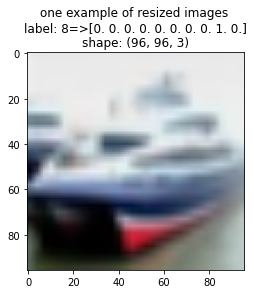

In [15]:
[x_train1,x_valid1,x_test1]=\
display_resize(x_train1,x_valid1,x_test1,
               y_valid1,cy_valid1,pixels)

In [16]:
model=premodel(pixels,512,mhandle,10)
history=model.fit(x=x_train1,y=cy_train1,batch_size=64,
                  epochs=10,callbacks=cb(fw),
                  validation_data=(x_valid1,cy_valid1))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              706224    
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 1,367,226
Trainable params: 1,348,682
Non-trainable params: 18,544
_________________________________________________________________


None

Train on 50000 samples, validate on 5000 samples
Epoch 1/10
49984/50000 [============================>.] - ETA: 0s - loss: 0.6504 - accuracy: 0.8038
Epoch 00001: val_loss improved from inf to 0.62566, saving model to weights.best.hdf5
50000/50000 [==============================] - 42s 849us/sample - loss: 0.6507 - accuracy: 0.8037 - val_loss: 0.6257 - val_accuracy: 0.8132
Epoch 2/10
49920/50000 [============================>.] - ETA: 0s - loss: 0.4607 - accuracy: 0.8637
Epoch 00002: val_loss improved from 0.62566 to 0.49895, saving model to weights.best.hdf5
50000/50000 [==============================] - 36s 721us/sample - loss: 0.4604 - accuracy: 0.8638 - val_loss: 0.4990 - val_accuracy: 0.8566
Epoch 3/10
49920/50000 [============================>.] - ETA: 0s - loss: 0.3977 - accuracy: 0.8866
Epoch 00003: val_loss improved from 0.49895 to 0.47558, saving model to weights.best.hdf5
50000/50000 [==============================] - 36s 728us/sample - loss: 0.3977 - accuracy: 0.8866 - val_l

In [17]:
model.load_weights(fw)
model.evaluate(x_test1,cy_test1)

5000/5000 [==============================] - 1s 268us/sample - loss: 0.4309 - accuracy: 0.8826


[0.43094850457906725, 0.8826]